# PARTITION COEFFICIENT OF D=0.2 USED TO MIMIC BEHAVIOUR OF A BASAL MAGMA OCEAN


## Start with small amount (D=0.001) in solid mantle, the rest (i.e., {D=0.2}-{D=0.001} results) in a basal magma ocean. Water in BMO then SLOWLY degasses into mantle over **(2 Gyr, for now; lifetime of BMO)** at a constant rate per timestep.
## This will require an extra reservoir to be saved to cycling files (& read-in) -- M_BMO()

# NOTE: Notebook without a basal magma ocean must be run first, as its results are read-in during the magma ocean phase of the simulation.


# Tested parameter space in Moore et al. (2022; in prep):
## Host star = {M8, M5, M1} (stellar tracks from Baraffe et al. 2015)
## Water inventory = {2, 4, 6, 8} Earth Oceans
## tau_MO = {10, 50, 100} Myr
## Orbital distance = {Hot Inner, Mid, Cold Outer} HZ edge (@t=4.5 Gyr, from Kopparapu et al. 2013)
# ---------------------------------

# This notebook uses data from Fig. 2b of Goldblatt et al. (2013) to determine T_surf based on OLR (=incoming flux) when below Simpson-Nakajima limit (282 W/m^2), and sets an upper limit during runaway greenhouse of T_surf = 1800 K (same as Barth et al. 2020).

# ASSUMPTIONS:
## No regassing during runaway greenhouse; all water in atmosphere (i.e., no surface water), and regassing parameterization relies on subduction. 
## Minimum water in mantle set to "desiccation limit" of Moore & Cowan (2020); lower limit prevents mantle viscosity --> infinity in calculations. 

## We treat MO solidification timescale as a free parameter; offset stellar tracks by 5 Myr to allow formation of M-Earths to complete.
## Use a CONSTANT thermospheric temperature = 400 K to calculate diffusion-limited escape, as in Luger & Barnes (2015)
## - Pure H2O atmosphere; we only track the mass of H2O in each reservoir throughout the model

######################################################################################################################

# Initialize notebook; import required functions/packages, and read in input parameters/variables from associated .txt files. The majority of these parameters are outlined in Table C1 of Moore & Cowan (2020). 

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Divide constants into three categories. See Moore & Cowan (2020) for details of each constant here. 

# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params_input.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Constants that could be varied
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params_input.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
# Test different betas; see if the code breaks
#beta = 0.12
#params2[11] = beta

# 3) Parameters that could be different between, e.g., different planets (currently based on Earth)
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params_input.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
dt_nom = 2.0e4*year
params3[8] = dt_nom

# NEW constants, for updated atmosphere & loss calculations
sigma_sb = 5.67e-8 #[W/m^2/K^4]; Stefan-Boltzmann constant
m_H = 1.66e-27 #[kg]; mass of H atom
k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
m_H2O = 18.02*m_H #molecular mass of water
m_air = 28.7*m_H #molecular mass of air on Earth
rho_water = 997. #[kg/m^3]; density of water
cp_water_vapour = 1.996e3 #[J/(kg K)]; specific heat capacity of water vapour (steam)
alb = 0.3 #albedo; value roughly similar to Earth
#alb = 0.75 #albedo; upper limit to roughly test "steam atmosphere"

# Model Functions/Calculated Constants

In [3]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x, params1, params2, params3): #NOTE: Requires non-dimensionalized mantle water mass fraction, and converts it (see Moore & Cowan 2020). 
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_w(x, params1, params2, params3):
    
    return np.exp(lnf_w(x, params1, params2, params3))

In [4]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(temp, x, params1, params2, params3): #x and T are non-dimensionalized here as well.
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    eta_scale = (np.exp(lnf_w(5.8e-4,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
        
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    # Let's take the 'desiccation limit' from Moore & Cowan (2020) as the minimum value to be 'trapped' in the mantle.
    if x <= 1.29e16/(f_M*M_E):
        return eta_0*(f_w(1.29e16/(f_M*M_E), params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))
    else:
        return eta_0*(f_w(x, params1, params2, params3)**(-r_fug)) * np.exp((E_a/R_g)*((1./temp) - (1./T_ref)))

In [5]:
# Planetary parameter scaling laws (for Rp, Rc, h, g, A, V) from Valencia et al. (2006).

# Planetary radius [m]
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

# Core radius [m]
def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

# Mantle thickness [m]
def h(M):
    return Rp(M) - Rc(M)

# Surface gravity [m/s^2]
def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

# Surface area [m^2]
def A(M):
    return 4.*np.pi*(Rp(M)**2.)

# Mantle volume [m^3]
def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

# Below relations based on Earth. 

# Mid-ocean ridge length [m]
def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

# Spreading rate [m/s]
def S(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*\
            (temp-T_surf)/(eta(temp,x,params1,params2,params3)*Ra_c))**(2.*beta))

# Rayleigh number
def Ra(t, temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (alpha*rho_m*g(M)*(temp - T_surf)*(h(M)**3))/(eta(temp, x, params1, params2, params3)*kappa)

# Nusselt number, for looking at heat flux -- UNUSED
def Nu(temp, x, T_surf, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (Ra(t, temp, x, T_surf, M, params1, params2, params3)/Ra_c)**beta

# Run MO simulation here.
## Initialize all variables & required functions for the MO simulations.

In [6]:
# Stellar evolution and surface temperature calculations

# Stellar evolution track, from Baraffe et al. 2015 (BHAC15)
# Read in stellar evolution track data
hostfile = 'BHAC15_0.13Msun_stellartrack.txt' # corresponds to M5 host star

# Function to read in all relevant data from corresponding host star file.
def hoststar(file):
    
    data = np.loadtxt(file, skiprows=3)
    log_age = data[:,1] #log(yr)
    T_eff_star = data[:,2] #[K]
    Lbol_Ls = data[:,3] #log luminosity
    R_Rs = data[:,5]

    Ls = 3.839e33 # [erg/s]; solar bolometric luminosity
    Lbol = np.zeros(len(Lbol_Ls))
    Lbol_Ls_star = np.zeros(len(Lbol_Ls))
    for idx in range(0,len(Lbol_Ls)):    
        Lbol[idx] = (10.**Lbol_Ls[idx])*Ls/1.0e7 #[W]
        Lbol_Ls_star[idx] = 10.**Lbol_Ls[idx]
    
    Rs = 6.96e10 #[cm]; solar radius
    Rstar = (R_Rs*Rs)/100.0 #[m]

    star_age = np.zeros(len(log_age)) #[s], for later calculations

    # Convert stellar age to time, in seconds, for compatibility with simulations. 
    for idx in range(0,len(log_age)):
        star_age[idx] = ((10.0**log_age[idx])*year)
    
    return star_age, Lbol, Lbol_Ls_star, T_eff_star
    
# Calculate the top-of-atmosphere bolometric flux, using BHAC15 stellar track.
def S_0(t, M, a_orb, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
    
    return np.interp(t_int, star_age, Lbol)/(4.*np.pi*(a_orb**2.))
    
# Calculate XUV luminosity at time, t. (Ribas et al., 2005; Luger & Barnes 2015)
def L_XUV(t, M, params1, params2, params3):
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    t_int = t + (5.0e6*year) #add offset of 5 Myr, to account for formation
  
    f_sat = 1.0e-3 #saturation fraction
    t_sat = 1.0e9*year #[s], saturation timescale (same as Luger & Barnes 2015)
    beta_XUV = -1.23
    
    if t <= t_sat:
        return f_sat*np.interp(t_int, star_age, Lbol)
    else: #t > t_sat
        return f_sat*((t_int/t_sat)**beta_XUV)*np.interp(t_int, star_age, Lbol)

# Calculate top-of-atmosphere XUV flux at time, t. [W/m^2] 
def F_XUV(t, M, a_orb, params1, params2, params3): 
        
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
        
    return L_XUV(t, M, params1, params2, params3)/(4.*np.pi*(a_orb**2.))

# Calculate the effective temperature of the planet at time, t. [K]
def f_T_eff(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

# Calculate the skin temperature (i.e., the isothermal stratosphere temperature). [K]
def T_strat(t, M, a_orb, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return ((1./2.)**0.25)*((S_0(t, M, a_orb, params1, params2, params3)*(1.0-alb))/(4.0*sigma_sb))**(0.25)

In [7]:
# Parameterize depth of a solidifying MO as a decreasing exponential. 

# Depth of MO at time, t, for a given MO solidification timescale (free parameter).
# Based on Fig. 3 of Barth et al. 2020, Fig. 4 of Schaefer et al. 2016
def d_MO(t, tau_MO, M): 
    
    d_MO_0 = h(M)/1000. # ENTIRE MANTLE BEGINS MOLTEN [km]
    beta_MO = 1./(np.exp(1.)-1)
    
    return (beta_MO*d_MO_0)*(np.exp((-t/tau_MO) + 1.) - 1)

# Temperature of MO as a function of MO depth, simply using liquidus temperature (Eqn. 1 of Elkins-Tanton 2008). [K]
def T_MO(t, tau_MO, M, a_orb, params1, params2, params3):
    
    r = (Rp(M) - d_MO(t, tau_MO, M))/1000. #[km]
    
    return (-1.16e-7*(r**3.)) + (0.0014*(r**2.)) - (6.382*r) + 1.444e4

## Set the initial amount of water in the MO, and calculate the initial concentration.

In [8]:
# Initial/constant parameters
D = 0.2 #solid-liquid H2O distribution coefficient, =0.2 to mimic basal magma ocean behaviour
R_p = Rp(M_E)/1000. #[km] #6400 km
R_c = Rc(M_E)/1000. #[km] #3000 km
rho = 3.0e3*1.0e9 #[kg/km^3] 
rho_MO = rho #density of MO [kg/km^3]; assumed to be same for solid mantle & MO for mass balance purposes

# Saturation concentration of water in MO
C_sat = 0.1 #H2O saturation limit of MO (Elkins-Tanton 2008)

# Initial mass of water in MO, and initial concentration in the MO.
M_init_array = np.array([6.])*1.4e21 #np.array([2., 4., 6., 8.])*1.4e21 #[kg]; 1.4e21 kg = 1 Earth Ocean
C_0_array = (3.*M_init_array)/(4.*np.pi*rho*(R_p**3. - R_c**3.))

## Parameterization of water in each inventory during MO solidification.


In [9]:
# Details in Moore et al. (2022); simplified from Boukare et al. (2019).
# RECALL r = R_p - d_MO(t)

# Concentration of water in liquid phase
def C_l(C_0, r):
    
    return C_0*((R_p**3.-R_c**3.)/(R_p**3.-r**3.))**(1.-D)

# Concentration of water in solid phase
def C_s(C_0, r):
    
    return D*C_l(C_0, r)

# Saturation radius [km]
def R_sat(C_0):
    
    return (R_p**3. - ((R_p**3. - R_c**3.)/((C_sat/C_0)**(1./(1.-D)))))**(1./3.)

# Mass of water in unsaturated MO [kg]
def M_MO_unsat(C_0, r):
    
    return C_l(C_0, r)*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

# Mass of water in unsaturated solid mantle [kg]
def M_SM_unsat(C_0, r):
    
    return C_0*(4.*np.pi/3.)*(rho_MO)*((R_p**3. - R_c**3.)**(1.-D))*\
            (((R_p**3. - R_c**3.)**D) - ((R_p**3. - r**3.)**D))

# Mass of water in saturated MO [kg]
def M_MO_sat(r):
    
    return C_sat*(4.*np.pi/3.)*rho_MO*(R_p**3. - r**3.)

# Mass of water in saturated solid mantle [kg]
def M_SM_sat(C_0, r):
    
    return M_SM_unsat(C_0, R_sat(C_0)) + D*C_sat*(4.*np.pi/3.)*(rho_MO)*(r**3.-R_sat(C_0)**3.)

## Functions required for atmospheric loss calculations.

In [10]:
# Loss rate equations from Luger & Barnes (2015)

# Energy-limited loss rate [kg/s]
def loss_rate_EL_MO(t, F_XUV, M): 
    
    # R_XUV = R_p for simplicity 
    # M = planetary mass
    
    G = 6.67e-11 #[m^3/(kg s^2)]; gravitational constant
    eps_XUV = 0.1 # XUV efficiency factor; varies within literature
    
    return eps_XUV*np.pi*F_XUV*(Rp(M)**3.)/(G*M)

# Diffusion-limited loss rate [kg/s]
def loss_rate_DL_MO(M):
    
    g_p = g(M)*100. #[cm s^-2], to match the units of b
    k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
    
    # Mole fractions of H & O (assuming all H2O is dissociated & pure H2O atmosphere)
    X_H = 2./3.
    X_O = 1./3.
    
    m_H = 1.66e-27 #[kg]; mass of H atom
    m_O = 16.*m_H #mass of O atom
        
    # Just take the thermospheric temperature as 400 K at all times, for now.
    b = 4.8e17*(400.**0.75) #[cm^-1 s^-1]
        
    return m_H*(np.pi*(Rp(M)**2.)*b*g_p*(m_O-m_H))/(k_B*400.*(1.+(X_O/X_H))) 
    
# Loss rate; EL during RG, minimum of EL/DL otherwise
def f_loss_MO(t, M, a_orb, params1, params2, params3): 
    
    ### Note that the "check" for not losing more water than on the surface is in the MO loop itself
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    # Runaway greenhouse limit; divide by 4 because planet is a sphere
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        # Energy-limited loss; set R_XUV = R_p, for simplicity
        d_loss = loss_rate_EL_MO(t, F_XUV(t, M, a_orb, params1, params2, params3), M) #[kg/s]                                                                                       
        
    else:
           
        # Take the lower value of EL and DL loss rates. 
        d_loss = np.minimum(loss_rate_EL_MO(t, F_XUV(t, M, a_orb, params1, params2, params3), M), \
                        loss_rate_DL_MO(M)) #[kg/s]
        
    return d_loss

In [11]:
## Orbital distances; used to determine Inner HZ, Mid HZ, and Outer HZ orbital positions.

# Read in Kopparapu et al. (2013) HZ data, for different stellar hosts.
data = np.loadtxt('HZs_orbits.dat', skiprows=2)
T_eff_kopp = data[:,0] #[K]
# All below values give S_eff -- see Eqn.(2) of Kopparapu+(2013)
RV_kopp = data[:,1] #Recent Venus
RG_kopp = data[:,2] #Runaway Greenhouse
MG_kopp = data[:,3] #Maximum Greenhouse
EM_kopp = data[:,4] #Early Mars

# Function to determine orbital distances
def f_a_orb(t, M, T_eff_star, Lbol_Ls_star, params1, params2, params3):
    
    # Effective flux at given orbital distance
    S_eff_RV = np.interp(T_eff_star, T_eff_kopp, RV_kopp) #recent Venus
    S_eff_RG = np.interp(T_eff_star, T_eff_kopp, RG_kopp) #runaway greenhouse
    S_eff_MG = np.interp(T_eff_star, T_eff_kopp, MG_kopp) #maximum greenhouse
    S_eff_EM = np.interp(T_eff_star, T_eff_kopp, EM_kopp) #early Mars
    
    # Orbital distance
    a_RV = (Lbol_Ls_star/S_eff_RV)**0.5 #[AU]
    a_RG = (Lbol_Ls_star/S_eff_RG)**0.5 #[AU]
    a_MG = (Lbol_Ls_star/S_eff_MG)**0.5 #[AU]
    a_EM = (Lbol_Ls_star/S_eff_EM)**0.5 #[AU]
    
    return a_RV, a_RG, a_MG, a_EM

In [12]:
# Stellar parameters required for MO sims, from host star input file.
star_age, Lbol, Lbol_Ls_star, T_eff_star = hoststar(hostfile)

# Roughly find limits at t = 4.5 Gyr (~age of Earth)
T_eff_star_45 = np.interp(4.5e9*year, star_age, T_eff_star)
Lbol_Ls_star_45 = np.interp(4.5e9*year, star_age, Lbol_Ls_star)
        
a_RV, a_RG, a_MG, a_EM = f_a_orb(4.5e9*year, M_E, T_eff_star_45, Lbol_Ls_star_45, params1, params2, params3)
    
# Take runaway greenhouse and maximum greenhouse limits as Inner/Outer HZ, and then the middle between them.
a_orb_array = np.array([(a_RG+a_MG)/2.]) #np.array([a_RG, (a_RG+a_MG)/2., a_MG])
a_orb_labels = ['Middle'] #['Runaway_GH', 'Middle', 'Maximum_GH']

## Able to loop through 3 solification timescales (10 Myr, 50 Myr, 100 Myr), and 4 water inventories (2, 4, 6, 8 Earth Oceans). Commented out to a single nominal value for each, for simplicity: 50 Myr, and 6 Earth Oceans.

In [13]:
# Magma ocean solidification timescale [s]
tau_MO_array = np.array([50.])*1.0e6*year #np.array([10., 50., 100.])*1.0e6*year
# tau_MO to be written to file name.
tau_MO_file = np.array([50.]) #np.array([10., 50., 100.]) #[Myr]

#M_init_array is the TOTAL initial water inventory, which starts in the MO; M_init_file should match that array.
M_init_file = np.array([6.]) #np.array([2., 4., 6., 8.]) #[Earth Oceans]

## Begin loop for the water inventories over time during the MO.

In [14]:
# Loop to determine whether or not MO is saturated & degas an atmosphere if it is
dt_MO = 2.0e3*year #2000 yr per timestep
M = M_E # planet mass, set to that of Earth

# Arrays to save final water inventories at end of MO simulation.
# Save "solid mantle" water to solid array FIRST, before defining the split in the next cell.
W_solid_array = np.zeros((len(tau_MO_array), len(M_init_array), len(a_orb_array)))
W_m_init_array = np.zeros((len(tau_MO_array), len(M_init_array), len(a_orb_array)))
W_BMO_init_array = np.zeros((len(tau_MO_array), len(M_init_array), len(a_orb_array)))
W_s_init_array = np.zeros((len(tau_MO_array), len(M_init_array), len(a_orb_array)))

# Path to save MO simulations to file. -- REPLACE WITH YOUR OWN DIRECTORY IF SAVING
save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'

# Loop over solidification timescale array.
for jdx in range(0, len(tau_MO_array)):

    t_MO_array = np.arange(0., (tau_MO_array[jdx]+dt_MO), dt_MO) # equivalent to MO solidification timescale
    r_array = R_p - d_MO(t_MO_array, tau_MO_array[jdx], M)

    # Loop over water inventory array. 
    for kdx in range(0, len(M_init_array)): 
        
        # Loop over orbital distance array. 
        for ldx in range(0,len(a_orb_array)):
        
            # Can comment out if only running a single simulation, but used to save results to file.
            save_file = 'basalMOresults.txt'
            filename = os.path.join(save_path, save_file)
            f = open(filename, 'w')

            # 4 TOTAL reservoirs, for mass balance throughout
            M_MO_array = np.zeros(len(r_array)) #magma ocean
            M_SM_array = np.zeros(len(r_array)) #solid mantle
            M_atmo_array = np.zeros(len(r_array)) #atmosphere
            M_lost_array = np.zeros(len(r_array)) #space "sink" for lost water
            
            # Other useful arrays for saving/plotting later
            EL_loss_MO_array = np.zeros(len(r_array)) #EL loss rate
            DL_loss_MO_array = np.zeros(len(r_array)) #DL loss rate
            loss_MO_array = np.zeros(len(r_array)) #actual loss rate
            TOA_flux_MO_array = np.zeros(len(r_array)) #top-of-atmosphere flux during MO
            a_orb = a_orb_array[ldx]*1.496e11 #[m]

            # Track MO temperature as a function of r/t.
            T_MO_array = np.zeros(len(t_MO_array))

            # Keep track of the total water inventory, for mass balance purposes throughout.
            M_total = M_init_array[kdx] #[kg]
            
            # Set initial parameters; all water in MO:
            M_MO_array[0] = M_total
            M_SM_array[0] = 0.
            M_atmo_array[0] = 0.
            EL_loss_MO_array[0] = loss_rate_EL_MO(t_MO_array[0], F_XUV(t_MO_array[0], M, a_orb, params1, params2, params3), M_E)
            DL_loss_MO_array[0] = loss_rate_DL_MO(M)
            loss_MO_array[0] = f_loss_MO(t_MO_array[0], M, a_orb, params1, params2, params3)
            TOA_flux_MO_array[0] = S_0(t_MO_array[0], M, a_orb, params1, params2, params3)
            T_MO_array[0] = T_MO(t_MO_array[0], tau_MO_array[jdx], M, a_orb, params1, params2, params3)
            
            # Comment in if writing to file; initial values for all above defined arrays.
            f.write(str(t_MO_array[0]) + '\t' + str(r_array[0]) + '\t' + str(T_MO_array[0]) + '\t' + str(M_MO_array[0]) +'\t' + \
                    str(M_SM_array[0]) + '\t' + str(M_atmo_array[0]) + '\t' + str(EL_loss_MO_array[0]) + '\t' + \
                    str(DL_loss_MO_array[0]) + '\t' +str(loss_MO_array[0]) + '\t' + str(TOA_flux_MO_array[0]) + '\n')

            # Begin loop, advancing r(t) forward in time by timestep dt_MO.
            for idx in range(1,len(r_array)):
    
                EL_loss_MO_array[idx] = loss_rate_EL_MO(t_MO_array[idx], F_XUV(t_MO_array[idx], M, a_orb, params1, params2, params3), M_E)
                DL_loss_MO_array[idx] = loss_rate_DL_MO(M)
                loss_MO_array[idx] = f_loss_MO(t_MO_array[idx], M, a_orb, params1, params2, params3)
                TOA_flux_MO_array[idx] = S_0(t_MO_array[idx], M, a_orb, params1, params2, params3)
                T_MO_array[idx] = T_MO(t_MO_array[idx], tau_MO_array[jdx], M, a_orb, params1, params2, params3)

                #MO undersaturated with water, i.e., r <= R_sat
                if r_array[idx] <= R_sat(C_0_array[kdx]):
        
                    M_MO_array[idx] = M_MO_unsat(C_0_array[kdx], r_array[idx])
        
                    M_SM_array[idx] = M_SM_unsat(C_0_array[kdx], r_array[idx])
        
                    M_atmo_array[idx] = 0.
        
                # MO saturated/supersaturated with water (r > R_sat); atmosphere forms    
                else: #r_array[idx] > R_sat()
        
                    M_MO_array[idx] = M_MO_sat(r_array[idx])
        
                    M_SM_array[idx] = M_SM_sat(C_0_array[kdx], r_array[idx])
        
                    M_atmo_array[idx] = M_total - M_SM_sat(C_0_array[kdx], r_array[idx]) - M_MO_sat(r_array[idx]) - M_lost_array[idx-1]
        
                   # Now add loss:
                    if M_atmo_array[idx] <= (loss_MO_array[idx]*dt_MO):
            
                        M_lost_array[idx] = M_lost_array[idx-1] + M_atmo_array[idx]
                        M_atmo_array[idx] = 0.  #no water in atmosphere; all lost to space
                        
                    else: #M_atmo_array[idx] > (loss_MO_array[idx]*dt_MO)
                    
                        M_atmo_array[idx] = M_atmo_array[idx] - (loss_MO_array[idx]*dt_MO)
                        M_lost_array[idx] = M_lost_array[idx-1] + (loss_MO_array[idx]*dt_MO)

                # Comment the below line back in, to write results to file, for each timestep in loop.
                f.write(str(t_MO_array[idx]) + '\t' + str(r_array[idx]) + '\t' + str(T_MO_array[idx]) + '\t' + str(M_MO_array[idx]) +'\t' + \
                    str(M_SM_array[idx]) + '\t' + str(M_atmo_array[idx]) + '\t' + str(EL_loss_MO_array[idx]) + '\t' + \
                    str(DL_loss_MO_array[idx]) + '\t' +str(loss_MO_array[idx]) + '\t' + str(TOA_flux_MO_array[idx]) + '\n')
                    
            # "Solid" water will be split between solid mantle and basal magma ocean, in the following cell.
            W_solid_array[jdx, kdx, ldx] = M_SM_array[-1]
            W_s_init_array[jdx, kdx, ldx] = M_atmo_array[-1]
            
            # Comment back in if writing to file.
            f.close()

# Now, need to split water between solid mantle (using ALREADY-RUN D=0.001 results) and basal MO (the excess of the above D=0.2 simulation results).
# Note that, because of this requirement, the notebook without a basal magma ocean included must be run first, as its results are read-in below. 

In [15]:
# Now, need to split water between solid mantle (using ALREADY-RUN D=0.001 results) and basal MO 
# (the excess of the above D=0.2 simulation results).
# First, need to read in data before splitting "solid mantle" reservoir between two reservoirs.
save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'

M_SM_final_all = np.zeros((len(tau_MO_array), len(M_init_array), len(a_orb_array)))

for jdx in range(0, len(tau_MO_array)):
    
    # Need length of data for the following arrays.
    save_file = 'MOresults.txt'
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)

    M_SM_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))

    for kdx in range(0, len(M_init_array)):
        
        for ldx in range(0, len(a_orb_array)): 
        
            # Read in data files for each model, and save them as the evolutionary path. 
            save_file = 'MOresults.txt'
            
            #print(save_file)
            filename = os.path.join(save_path, save_file)
            tmp_data = np.loadtxt(filename)
            M_SM_paths[kdx,ldx,:] = tmp_data[:,4]
            
            M_SM_final_all[jdx, kdx, ldx] = M_SM_paths[kdx,ldx,-1]     

# Now, split the water between the two reservoirs accordingly. These will be used in the next section. 
W_m_init_array = M_SM_final_all
W_BMO_init_array = W_solid_array - W_m_init_array

# Now we can define cycling-specific equations, to be used in the simulations for the rest of the M-Earths lifetime.
## Same parameter space over tau_MO, water inventory, and orbital distances is followed.
## Recall that the final water inventories in solid mantle and surface will be used as input parameters for cycling simulations.

In [16]:
# Seafloor pressure
def P(s, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return M*g(M)*s/(f_b*4*np.pi*(Rp(M)**2))

# Hydration depth
def d_h(t, temp, T_surf, x, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    return (h(M)**(1.0-3.0*beta))*((temp-T_surf)**(-(1.0+beta)))*\
        (T_serp-T_surf)*((eta(temp,x,params1,params2,params3)*kappa*Ra_c/(alpha*rho_m*g(M)))**beta)

# Radionuclide heating, using 4 most common Earth mantle species (i.e., nominal bulk silicate Earth, 21 ppb U)
# (Schaefer & Sasselov 2015, Eqn. (4), with constants as given in Laura's MATLAB code (see refs there))
def Q_sum(t, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    
    # Mantle concentration of element by mass (Schubert et al. 2001, Ch. 4)
    Uran = 21e-9; #[U] = 21 ppb
    C_238U = 0.9927 * Uran;
    C_235U = 0.0072 * Uran;
    C_40K = 1.28 * Uran;
    C_232Th = 4.01 * Uran;
    
    # Heat production per unit mass (Schubert et al. 2001, Ch. 4)
    H_238U = 9.37e-5;
    H_235U = 5.69e-4;
    H_232Th = 2.69e-5;
    H_40K = 2.79e-5;
    
    # Decay constants
    lam_238U = 0.155e-9;
    lam_235U = 0.985e-9;
    lam_232Th = 0.0495e-9;
    lam_40K = 0.555e-9;
    
    return rho_m*(C_238U*H_238U*np.exp(lam_238U*(4.6e9-t)) + C_235U*H_235U*np.exp(lam_235U*(4.6e9-t)) + \
            C_232Th*H_232Th*np.exp(lam_232Th*(4.6e9-t)) + C_40K*H_40K*np.exp(lam_40K*(4.6e9-t)))

In [17]:
# Things that need to be calculated with constants and above functions:
# NOTE: If dimensions are being used anyway, many of these are redundant/won't be used in the code.
# HOWEVER, the way the functions are written depend on params4 as an input, so leave for now.
# Details can mostly be found in Komacek & Abbot (2016) and Moore & Cowan (2020).
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(5.8e-4,params1,params2,params3)))**(-r_fug)
eta_0 = 1.0e21/eta_scale
#f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = 1.0e-5 #CONSERVATIVELY CHOSEN FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters; required due to definition of following functions
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

## Additional Atmosphere Temperature & Loss Functions

In [18]:
# Variables/functions, required for the adiabats and water saturation pressure.

P_0_star = 1.4e11 #[Pa]
l_c_NJ = 43655 #[J/mol] 
R_gas_NJ = 8.314 #[J/mol/K]

# Saturation water vapour pressure, from Nakajima et al. (1992)
def P_star(T): 
    
    return P_0_star*np.exp(-l_c_NJ/(R_gas_NJ*T))

In [19]:
# Calculate surface temperature based on Fig. 2b of Goldblatt et al. (2013).
# If above Simpson-Nakajima limit, set to same RG value as Barth et al. (2020): T_surf = 1800 K. 

# Use Goldblatt provided data for pure H2O atmosphere.
data = np.loadtxt('Goldblatt_Tsurf_OLR.txt')
T_surf_gb = data[:,0] # [K]
OLR_gb = data[:,1] #[K] 

def T_surf_OLR(t, M, alb, a_orb, params1, params2, params3):
    
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)): #runaway greenhouse
                
        return 1800. #~maximum T_surf corresponding to given OLR
    
    else: #not in runaway greenhouse
        
        # Set OLR = absorbed flux
        OLR = (S_0(t, M, a_orb, params1, params2, params3)/4.)*(1.-alb)
        
        # Do a simple linear interpolation.
        z = np.polyfit(T_surf_gb[0:4], OLR_gb[0:4], 1)

        if OLR <= np.min(OLR_gb): #arbitrary lower limit
            
            return np.min(T_surf_gb) + ((OLR - np.min(OLR_gb))/z[0])
        
        else:
            
            return np.interp(OLR, OLR_gb, T_surf_gb)

## Energy-limited & diffusion-limited loss, from Luger & Barnes (2015) (same as MO definitions, but redefined here if ever running cycling without MO simulation prior)

In [20]:
# Energy-limited escape rate
def loss_rate_EL(t, F_XUV, R_XUV, M): #[kg/s]

    
    G = 6.67e-11
    eps_XUV = 0.1
    
    return eps_XUV*np.pi*F_XUV*Rp(M)*(R_XUV**2.)/(G*M)

# Diffusion-limited escape rate
def loss_rate_DL(t, T_surf, T_strat, M):
    
    g_p = g(M)*100. #[cm s^-2], to match the units of b
    k_B = 1.38e-23 #[m^2 kg s^-2 K^-1]; Boltzmann constant
    
    # Mole fractions of H & O (assuming all H2O is dissociated)
    X_H = 2./3.
    X_O = 1./3.
    
    m_H = 1.66e-27 #[kg]; mass of H atom
    m_O = 16.*m_H
        
    # Just take the thermospheric temperature as 400 K at all times, for now.
    b = 4.8e17*(400.**0.75) #[cm^-1 s^-1]
        
    return m_H*(np.pi*(Rp(M)**2.)*b*g_p*(m_O-m_H))/(k_B*400.*(1.+(X_O/X_H))) 

# Cycling Functions; see Moore & Cowan (2020) for thermal evolution, and Moore et al. (2022) for details of cycling. 

In [21]:
# Thermal evolution of mantle temperature [K]
def f_delta_temp(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M) #mantle water mass fraction
    s = W_s/M #surface water mass fraction
    
    return (1./(rho_m*c_p))*((Q_sum(t, M, params1, params2, params3)) - \
        (k*A(M)*(temp-T_surf)/(h(M)*V(M)))*(Ra(t, temp, x, T_surf, M, params1, params2, params3)/Ra_c)**beta)

# Degassing rate
def f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    # Mantle temperature check (if below solidus, no melting)
    if temp > T_sol_dry-K_cnst*x**gamma: 
    
        # Piecewise limit from Cowan & Abbot (2014)
        if x > 0. and s > 0. and f_degasE*(P(s, M, params1, params2, params3)/P_E)**(-mu) < 1.:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x*rho_m*d_melt*\
                (f_degasE*(P(s, M, params1, params2, params3)/P_E)**(-mu))*\
                ((temp-(T_sol_dry-K_cnst*x**gamma))/(T_liq_dry-T_sol_dry))**theta)
    
        elif x > 0. and s > 0. and f_degasE*(P(s, M, params1, params2, params3)/P_E)**(-mu) >= 1.:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x*rho_m*d_melt*\
                (1.)*((temp-(T_sol_dry-K_cnst*x**gamma))/(T_liq_dry-T_sol_dry))**theta)
    
        elif x > 0. and s <= 0.:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x*rho_m*d_melt*\
                (1.)*((temp-(T_sol_dry-K_cnst*x**gamma))/(T_liq_dry-T_sol_dry))**theta)
    
        else: # x <= 0.; no degassing
            return 0.
        
    else: # temp <= T_sol_dry-K_cnst*x**gamma; no degassing
        return 0.
    
# Regassing rate (adding regassing check of Cowan & Abbot 2014 to T-dependent regassing of Schaefer & Sasselov 2015)
def f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        # Runaway greenhouse; all water in atmosphere so NO regassing!!!
        return 0.
        
    else:
    
        # Piecewise limit from Cowan & Abbot (2014)
        if x > 0. and s > 0. and d_h(t, temp, T_surf, x, M, params1, params2, params3)*(P(s, M, params1, params2, params3)/P_E)**sigma < d_b:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x_h*rho_c*chi_r*\
                d_h(t, temp, T_surf, x, M, params1, params2, params3)*(P(s, M, params1, params2, params3)/P_E)**sigma)
    
        elif x > 0. and s > 0. and d_h(t, temp, T_surf, x, M, params1, params2, params3)*(P(s, M, params1, params2, params3)/P_E)**sigma >= d_b:
            return L_MOR(M)*S(t, temp, x, T_surf, M, params1, params2, params3)*(x_h*rho_c*chi_r*d_b)
    
        elif x <= 0. and s > 0.: # constant spreading rate assumed if mantle dry
            return L_MOR(M)*(0.1/year)*(x_h*rho_c*chi_r*d_b)
    
        elif s <= 0.: # no regassing
            return 0.
    
# Water loss rate; either energy- or diffusion-limited
def f_loss(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    # Runaway greenhouse limit; divide by 4 because planet is a sphere
    if S_0(t, M, a_orb, params1, params2, params3)/4. > (282./(1.-alb)):
        
        # Energy-limited loss; set R_XUV = R_p, for simplicity
        M_loss = loss_rate_EL(t, F_XUV(t, M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
        
    else:
           
        # Take the lower value of EL and DL loss rates. 
        M_loss = np.minimum(loss_rate_EL(t, F_XUV(t, M, a_orb, params1, params2, params3), Rp(M), M), \
                        loss_rate_DL(t, T_surf, T_strat, M)) #[kg/s]
        
    # Our timesteps are comparatively long, replenishment time above exobase is ~instantaneous; therefore, we can take 
    # water directly from the surface reservoir.
    # Piecewise definition, so you don't lose more than on the surface
    if M_loss < W_s/dt:
        return M_loss
    else:
        return W_s/dt
    
    #return 0. #no loss

## The basal magma ocean simulation requires the initial water in the basal magma ocean, W_BMO_init (defined at the end of the magma ocean simulation, above) and the solidification time/lifetime of the basal magma ocean, tau_BMO (defined below in the "cycling" simulation loop cell).
## These values are required for f_delta_W_m and f_cycling.

In [22]:
# Change in mantle water with time
def f_delta_W_m(t, temp, W_m, W_s, T_surf, alb, dt, M, a_orb, params1, params2, params3, params4, W_BMO_init, tau_BMO):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    # Rate of degassing from basal MO to solid mantle, PER SECOND, for lifetime of BMO
    if t <= tau_BMO:
        
        W_BMO_rate = W_BMO_init/tau_BMO
        
    else: #t > tau_BMO
        
        W_BMO_rate = 0.
    
    d_W_m = f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4) + \
            W_BMO_rate #slow but constant degassing of water from BMO to mantle, PER SECOND
    
    # Mantle water capacity check
    if W_m + (d_W_m*dt) <= 12.0*1.4e21:
        return d_W_m
    else:
        return ((12.0*1.4e21) - W_m)/dt

# Change in surface water with time
def f_delta_W_s(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    x = W_m/(f_M*M)
    s = W_s/M
    
    d_W_m = f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4)
    
    # Mantle water capacity check
    if W_m + (d_W_m*dt) <= 12.0*1.4e21:
        return f_degas(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4) - \
            f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_loss(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4)
    else:
        return -(((12.0*1.4e21) - W_m)/dt) - \
            f_regas(t, temp, W_m, W_s, T_surf, alb, M, a_orb, params1, params2, params3, params4) - \
            f_loss(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4)

def f_cycling(t, z, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4, W_BMO_rate, tau_BMO):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp = z[0]
    W_m = z[1]
    W_s = z[2]
    
    return [f_delta_temp(t, temp, W_m, W_s, T_surf, M, params1, params2, params3, params4),\
                f_delta_W_m(t, temp, W_m, W_s, T_surf, alb, dt, M, a_orb, params1, params2, params3, params4, W_BMO_rate, tau_BMO),\
                f_delta_W_s(t, temp, W_m, W_s, T_surf, T_strat, alb, dt, M, a_orb, params1, params2, params3, params4)]

In [23]:
## Orbital distances; repeated here in case prior MO simulation is not followed.
# Read in Kopparapu+(2013) HZ data, for different stellar hosts.

data = np.loadtxt('HZs_orbits.dat', skiprows=2)
T_eff_kopp = data[:,0] #[K]
# All below values give S_eff -- see Eqn.(2) of Kopparapu+(2013)
RV_kopp = data[:,1] #Recent Venus
RG_kopp = data[:,2] #Runaway Greenhouse
MG_kopp = data[:,3] #Maximum Greenhouse
EM_kopp = data[:,4] #Early Mars

def f_a_orb(t, M, T_eff_star, Lbol_Ls_star, params1, params2, params3):
    
    S_eff_RV = np.interp(T_eff_star, T_eff_kopp, RV_kopp)
    S_eff_RG = np.interp(T_eff_star, T_eff_kopp, RG_kopp)
    S_eff_MG = np.interp(T_eff_star, T_eff_kopp, MG_kopp)
    S_eff_EM = np.interp(T_eff_star, T_eff_kopp, EM_kopp)
    
    a_RV = (Lbol_Ls_star/S_eff_RV)**0.5 #[AU]
    a_RG = (Lbol_Ls_star/S_eff_RG)**0.5 #[AU]
    a_MG = (Lbol_Ls_star/S_eff_MG)**0.5 #[AU]
    a_EM = (Lbol_Ls_star/S_eff_EM)**0.5 #[AU]
    
    return a_RV, a_RG, a_MG, a_EM

# Time-dependent Cycling & Loss Simulations

In [24]:
# Need various values of initial water inventories -- USE OUTPUT FROM ABOVE MO MODEL RUNS.

#tau_MO_array are the solidification timescales.
#tau_MO_array = np.array([50.])*1.0e6*year # np.array([10., 50., 100.])*1.0e6*year 
tau_MO_file = np.array([50.]) # np.array([10., 50., 100.]) #[Myr]
#M_init_array is the TOTAL initial water inventory, which starts in the MO.
#M_init_array = np.array([6.])*1.4e21 #np.array([2., 4., 6., 8.])*1.4e21 #[Earth Oceans]
M_init_file = np.array([6.]) #np.array([2., 4., 6., 8.]) #[Earth Oceans]

# These two values are defined at end of MO loop; can also set them here if MO simulation not used.
#W_m_init_array is the mantle water
#W_s_init_array is the surface water

# Also need orbital distances for the given host star
star_age, Lbol, Lbol_Ls_star, T_eff_star = hoststar(hostfile)
    
# Roughly find limits at t = 4.5 Gyr (~age of Earth)
T_eff_star_45 = np.interp(4.5e9*year, star_age, T_eff_star)
Lbol_Ls_star_45 = np.interp(4.5e9*year, star_age, Lbol_Ls_star)
        
a_RV, a_RG, a_MG, a_EM = f_a_orb(4.5e9*year, M_E, T_eff_star_45, Lbol_Ls_star_45, params1, params2, params3)
    
# For now, take runaway greenhouse and maximum greenhouse limits, and then the middle between them.
a_orb_array = np.array([(a_RG+a_MG)/2.]) #np.array([a_RG, (a_RG+a_MG)/2., a_MG])
a_orb_labels = ['Middle'] #['Runaway_GH', 'Middle', 'Maximum_GH']

## Change the cell below from MARKDOWN to CODE if running simulations.
## If just reading in files (below this simulation loop), run all cells above this point, and just read in MO & cycling data from files.
## ***NOTE FOR THIS CELL: YOU MAY GET SOME ERRORS WHILE RUNNING THIS INTEGRATION; THE LOOP CONTINUES IN A DIFFERENT MANOR WHEN IF THE VODE FAILS. EVEN WITH ERRORS, LET IT RUN, AND DOUBLE-CHECK THE RESULTS WHEN PLOTTED TO FIGURE AFTERWARDS -- IF IT IS SMOOTH THEN NO PROBLEM! OTHERWISE, NEED TO PLAY WITH THE INTEGRATION IN THE BELOW CELL

In [25]:
# Loop through the above arrays, by solidification timescale and water inventory.

# Timescale over which basal magma ocean will degas into solid mantle.
tau_BMO = 2.0e9*year # 2 Gyr (conservatively chosen for now, set globally for this simulation)

# Loop over MO solidification timescales.
for jdx in range(0, len(tau_MO_array)):
    
    # Loop over initial water inventories.
    for kdx in range(0, len(M_init_array)):
        
        # Loop over orbital distances.
        for ldx in range(0, len(a_orb_array)):
        
            # Set initial conditions.
            t0 = tau_MO_array[jdx] #START AT END OF MO PHASE
            # z0 = [mantle temperature, mantle water, surface water]
            z0 = [3000., W_m_init_array[jdx, kdx, ldx], W_s_init_array[jdx, kdx, ldx]] #[K] [kg] [kg]
            M = M_E
            # Atmosphere initial conditions.
            m = m_H2O #molecular mass of water 
            a_orb = a_orb_array[ldx]*1.496e11 #[m]
            alb = 0.3 #albedo; redefined here for clarity
            T_surf_0 = T_surf_OLR(t0, M, alb, a_orb, params1, params2, params3)
            T_strat_0 = T_strat(t0, M, a_orb, params1, params2, params3)
            # Define max time, timestep, arrays to be filled within the integration loop.
            t1 = 5.0e9*year #5 Gyr
            dt = 2.0e4*year #20,000 yr per timestep
            # Water in basal magma ocean; this value was defined at the end of the magma ocean phase.
            # Recall that it is the difference between D=0.2 and D=0.001 magma ocean simulations.
            W_BMO_init = W_BMO_init_array[jdx, kdx, ldx]

            # Set up function to be integrated.
            r = ode(f_cycling).set_integrator('vode')
            # NOTE: Setting the initial values requires the basal magma ocean variables (previously described).
            r.set_initial_value(z0, t0).set_f_params(T_surf_0,T_strat_0,alb,dt,M,a_orb,params1,params2,params3,params4,W_BMO_init,tau_BMO)

            # Define arrays to be filled within the integration loop.
            t_array = np.zeros(int((t1-t0)/dt)+1)
            # Cycling
            T_array = np.zeros(int((t1-t0)/dt)+1)
            W_m_array = np.zeros(int((t1-t0)/dt)+1)
            W_s_array = np.zeros(int((t1-t0)/dt)+1)
            regas_array = np.zeros(int((t1-t0)/dt)+1)
            degas_array = np.zeros(int((t1-t0)/dt)+1)
            # Atmosphere
            T_surf_array = np.zeros(int((t1-t0)/dt)+1)
            T_strat_array = np.zeros(int((t1-t0)/dt)+1)
            TOA_flux_array = np.zeros(int((t1-t0)/dt)+1)
            loss_array = np.zeros(int((t1-t0)/dt)+1)
            EL_array = np.zeros(int((t1-t0)/dt)+1)
            DL_array = np.zeros(int((t1-t0)/dt)+1)
            # Basal magma ocean
            W_BMO_array = np.zeros(int((t1-t0)/dt)+1)
        
            # Write results to file, for plotting later. -- CHANGE PATH IF SAVING TO FILE. 
            save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'
            save_file = 'basalMO_cyclingresults.txt'
            filename = os.path.join(save_path, save_file)
            f = open(filename, 'w')
        
            # Initial values in the arrays.
            t_array[0] = t0
            # Cycling
            T_array[0] = z0[0]
            W_m_array[0] = z0[1]
            W_s_array[0] = z0[2]
            regas_array[0] = f_regas(t0, z0[0], z0[1], z0[2], T_surf_0, alb, M, a_orb, params1, params2, params3, params4)
            degas_array[0] = f_degas(t0, z0[0], z0[1], z0[2], T_surf_0, M, params1, params2, params3, params4)
            # Atmosphere
            T_surf_array[0] = T_surf_0
            T_strat_array[0] = T_strat_0
            TOA_flux_array[0] = S_0(t0, M, a_orb, params1, params2, params3)
            loss_array[0] = f_loss(t0, z0[0], z0[1], z0[2], T_surf_0, T_strat_0, alb, dt, M, a_orb, params1, params2, params3, params4)
            EL_array[0] = loss_rate_EL(t0, F_XUV(t0, M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
            DL_array[0] = loss_rate_DL(t0, T_surf_0, T_strat_0, M) #[kg/s]
            # Basal magma ocean
            W_BMO_array[0] = W_BMO_init 
        
            # Write initial values to file, including basal MO. Comment back in if saving to file.
            f.write(str(t_array[0]) + '\t' + str(T_array[0]) + '\t' + str(W_m_array[0]) +'\t' + str(W_s_array[0]) + \
                    '\t' + str(degas_array[0]) + '\t' + str(regas_array[0]) + '\t' + str(T_surf_array[0]) + '\t' + \
                    str(T_strat_array[0]) + '\t' + str(TOA_flux_array[0]) + '\t' + str(loss_array[0]) + '\t' + \
                    str(EL_array[0]) + '\t' + str(DL_array[0]) + '\t' + str(W_BMO_array[0]) + '\n')

            # Integrate the above function.
            idx = 1
            start_time = time.time() #time how long each loop takes
            for idx in range(1,len(t_array)):
    
                if r.successful() == True:
                    r.integrate(r.t+dt)
                    t_array[idx] = r.t
                    T_array[idx] = r.y[0]
                    W_m_array[idx] = r.y[1]
                    W_s_array[idx] = r.y[2]
        
                    T_surf_array[idx] = T_surf_OLR(r.t, M, alb, a_orb, params1, params2, params3)
                    T_strat_array[idx] = T_strat(r.t, M, a_orb, params1, params2, params3)
                    TOA_flux_array[idx] = S_0(r.t, M, a_orb, params1, params2, params3)
        
                    regas_array[idx] = f_regas(r.t, r.y[0], r.y[1], r.y[2], T_surf_array[idx], alb, M, a_orb, params1, params2, params3, params4)
                    degas_array[idx] = f_degas(r.t, r.y[0], r.y[1], r.y[2], T_surf_array[idx], M, params1, params2, params3, params4)
                    loss_array[idx] = f_loss(r.t, r.y[0], r.y[1], r.y[2], T_surf_array[idx], T_strat_array[idx], alb, dt, M, a_orb, params1, params2, params3, params4)
                    EL_array[idx] = loss_rate_EL(r.t, F_XUV(r.t, M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
                    DL_array[idx] = loss_rate_DL(r.t, T_surf_array[idx], T_strat_array[idx], M) #[kg/s]
                    
                     # Keep track of water in basal MO.
                    if r.t <= tau_BMO:
                        W_BMO_array[idx] = W_BMO_init*((-r.t/tau_BMO)+1)
                    else: #r.t > tau_BMO
                        W_BMO_array[idx] = 0.
        
                    # Write current values to file.
                    f.write(str(t_array[idx]) + '\t' + str(T_array[idx]) + '\t' + str(W_m_array[idx]) +'\t' + str(W_s_array[idx]) + \
                        '\t' + str(degas_array[idx]) + '\t' + str(regas_array[idx]) + '\t' + str(T_surf_array[idx]) + '\t' + \
                        str(T_strat_array[idx]) + '\t' + str(TOA_flux_array[idx]) + '\t' + str(loss_array[idx]) + '\t' + \
                        str(EL_array[idx]) + '\t' + str(DL_array[idx]) + '\t' + str(W_BMO_array[idx]) + '\n')
                
                elif r.successful() == False: #slightly less elegant, more direct way
                    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
                    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
                    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt_nom = params3
                    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                        eta_scale, eta_0, f_w, f_wtwid_min, E = params4
       
                    t_array[idx] = t_array[idx-1] + dt
                    T_array[idx] = T_array[idx-1] + \
                        f_delta_temp(t_array[idx-1], T_array[idx-1], W_m_array[idx-1], W_s_array[idx-1], T_surf_array[idx-1], M, params1, params2, params3, params4)*dt
                    # Basal magma ocean variables required for calculation of W_m_array.
                    W_m_array[idx] = W_m_array[idx-1] + \
                        f_delta_W_m(t_array[idx-1], T_array[idx-1], W_m_array[idx-1], W_s_array[idx-1], T_surf_array[idx-1], alb, dt, M, a_orb, params1, params2, params3, params4, W_BMO_init, tau_BMO)*dt
                    W_s_array[idx] = W_s_array[idx-1] + \
                        f_delta_W_s(t_array[idx-1], T_array[idx-1], W_m_array[idx-1], W_s_array[idx-1], T_surf_array[idx-1], T_strat_array[idx-1], alb, dt, M, a_orb, params1, params2, params3, params4)*dt
                
                    T_surf_array[idx] = T_surf_OLR(t_array[idx], M, alb, a_orb, params1, params2, params3)
                    T_strat_array[idx] = T_strat(t_array[idx], M, a_orb, params1, params2, params3)
                    TOA_flux_array[idx] = S_0(t_array[idx], M, a_orb, params1, params2, params3)
        
                    regas_array[idx] = f_regas(t_array[idx], T_array[idx-1], W_m_array[idx], W_s_array[idx], T_surf_array[idx], alb, M, a_orb, params1, params2, params3, params4)
                    degas_array[idx] = f_degas(t_array[idx], T_array[idx-1], W_m_array[idx], W_s_array[idx], T_surf_array[idx], M, params1, params2, params3, params4)
                    loss_array[idx] = f_loss(t_array[idx], T_array[idx-1], W_m_array[idx], W_s_array[idx], T_surf_array[idx], T_strat_array[idx], alb, dt, M, a_orb, params1, params2, params3, params4)
                    EL_array[idx] = loss_rate_EL(t_array[idx], F_XUV(t_array[idx], M, a_orb, params1, params2, params3), Rp(M), M) #[kg/s]
                    DL_array[idx] = loss_rate_DL(t_array[idx], T_surf_array[idx], T_strat_array[idx], M) #[kg/s]
                
                    # Keep track of water in basal MO.
                    if t_array[idx] <= tau_BMO:
                        W_BMO_array[idx] = W_BMO_init*((-t_array[idx]/tau_BMO)+1)
                    else: #r.t > tau_BMO
                        W_BMO_array[idx] = 0.
                
                    # Write current values to file.
                    f.write(str(t_array[idx]) + '\t' + str(T_array[idx]) + '\t' + str(W_m_array[idx]) +'\t' + str(W_s_array[idx]) + \
                        '\t' + str(degas_array[idx]) + '\t' + str(regas_array[idx]) + '\t' + str(T_surf_array[idx]) + '\t' + \
                        str(T_strat_array[idx]) + '\t' + str(TOA_flux_array[idx]) + '\t' + str(loss_array[idx]) + '\t' + \
                        str(EL_array[idx]) + '\t' + str(DL_array[idx]) + '\t' + str(W_BMO_array[idx]) + '\n')

            if W_m_array[-1]+W_s_array[-1] <= 1.29e16: #desiccation limit from Moore & Cowan (2020); can also be checked later if data saved to file
                print('Planet Desiccated')
            
            # Comment back in if saving to file.
            f.close()
    
            end_time = time.time()
            print(end_time-start_time, ' s') #print the amount of time it took for the loop to run.

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


200.6679608821869  s


# Read in the simulation results from files. 
## Read in all files for host star, and save initial/final water inventories.
## Since different MO solidification timescales with lead to different lengths of arrays (because same timestep length), during both MO and cycling phases, will need to be read in & plotted separately if multiple are tested.

### Individual read-ins for each solidification timescale.

In [26]:
print(tau_MO_file, 'Myr')
# Choose which solidification timescale will be read-in.
# TRY FOR ONLY A SINGLE SOLIDIFICATION TIMESCALE, TO ALLOW PLOTTING. -- tau_MO = 10 Myr, [50 Myr], or 100 Myr
tau_idx = 0 #0-2, if testing 3 different scales
tau_MO = tau_MO_file[tau_idx]*1.0e6 #[Myr]

[50.] Myr


## # NOTE: If only running a single simulation, these next two cells can be skipped.

In [27]:
# Read in MO results (pre-cycling).

save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'

#tolerance = 1.29e16 #[kg]; if below this, set water = 0 --> DESICCATED

# Initial water content in each reservoir
M_MO_initial = np.zeros((len(M_init_array), len(a_orb_array)))
M_SM_initial = np.zeros((len(M_init_array), len(a_orb_array)))
M_atmo_initial = np.zeros((len(M_init_array), len(a_orb_array)))

# Final water content in each reservoir
M_MO_final = np.zeros((len(M_init_array), len(a_orb_array)))
M_SM_final = np.zeros((len(M_init_array), len(a_orb_array)))
M_atmo_final = np.zeros((len(M_init_array), len(a_orb_array)))

# Initial and final mantle temperatures, if needed.
T_MO_initial = np.zeros((len(M_init_array), len(a_orb_array)))
T_MO_final = np.zeros((len(M_init_array), len(a_orb_array)))
    
# Need length of data for the following arrays.
save_file = 'basalMOresults.txt'    
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array; same for all.
t_MO_array = tmp_data[:, 0]

# Overall evolution path for each reservoir & mantle temperature & surface temperature.
M_MO_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
M_SM_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
M_atmo_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
r_sol_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
T_MO_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
TOA_flux_MO_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))

loss_MO_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
EL_MO_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
DL_MO_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
    
for kdx in range(0, len(M_init_array)):
        
    for ldx in range(0, len(a_orb_array)): 
        
        # Read in data files for each model, and save them as the evolutionary path. 
        save_file = 'basalMOresults.txt'
            
        print(save_file)
        filename = os.path.join(save_path, save_file)
        tmp_data = np.loadtxt(filename)
        r_sol_paths[kdx,ldx,:] = tmp_data[:,1]
        T_MO_paths[kdx,ldx,:] = tmp_data[:,2]
        M_MO_paths[kdx,ldx,:] = tmp_data[:,3]
        M_SM_paths[kdx,ldx,:] = tmp_data[:,4]
        M_atmo_paths[kdx,ldx,:] = tmp_data[:,5]
        EL_MO_paths[kdx,ldx,:] = tmp_data[:,6]
        DL_MO_paths[kdx,ldx,:] = tmp_data[:,7]
        loss_MO_paths[kdx,ldx,:] = tmp_data[:,8]
        TOA_flux_MO_paths[kdx,ldx,:] = tmp_data[:,9]

        # Save initial and final values to corresponding arrays.
        M_MO_initial[kdx, ldx] = M_MO_paths[kdx,ldx,0]
        M_SM_initial[kdx, ldx] = M_SM_paths[kdx,ldx,0]
        M_atmo_initial[kdx, ldx] = M_atmo_paths[kdx,ldx,0]
    
        T_MO_initial[kdx, ldx] = T_MO_paths[kdx,ldx,0]
        T_MO_final[kdx, ldx] = T_MO_paths[kdx,ldx,-1]
        
        M_MO_final[kdx, ldx] = M_MO_paths[kdx,ldx,-1]
        M_SM_final[kdx, ldx] = M_SM_paths[kdx,ldx,-1]     
        M_atmo_final[kdx, ldx] = M_atmo_paths[kdx,ldx,-1]
            
#print('Zero water: ', 'W_m: ', W_m_zero_count_all, 'W_s: ', W_s_zero_count_all, 'both: ', both_zero_count_all)

basalMOresults.txt


In [28]:
#Read in cycling files (post-MO). 

save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'

tolerance = 1.29e16 #[kg]; if below this, set water = 0 --> DESICCATED

# Initial water content in each reservoir
W_m_initial = np.zeros((len(M_init_array), len(a_orb_array)))
W_s_initial = np.zeros((len(M_init_array), len(a_orb_array)))
W_BMO_initial = np.zeros((len(M_init_array), len(a_orb_array)))

# Final water content in each reservoir
W_m_final = np.zeros((len(M_init_array), len(a_orb_array)))
W_s_final = np.zeros((len(M_init_array), len(a_orb_array)))
#By definition, W_BMO will always be zero by the end of the simulation.

# Initial and final mantle temperatures, if needed.
T_initial = np.zeros((len(M_init_array), len(a_orb_array)))
T_final = np.zeros((len(M_init_array), len(a_orb_array)))

# How many reach exactly zero in one/both reservoir/s at the end?
W_m_zero_count = 0.
W_s_zero_count = 0.
both_zero_count = 0.
    
# Need length of data for the following arrays.
save_file = 'basalMO_cyclingresults.txt'    
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array; same for all.
t_array = tmp_data[:, 0]

# Overall evolution path for each reservoir & mantle temperature & surface temperature.
W_m_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
W_s_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
T_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
T_surf_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
TOA_flux_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
W_BMO_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))

# Overall evolution path for degassing and regassing rates.
degas_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
regas_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
loss_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
EL_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
DL_paths = np.zeros((len(M_init_array),len(a_orb_array),len(tmp_data)))
    
for kdx in range(0, len(M_init_array)):
        
    for ldx in range(0, len(a_orb_array)): 
        
        # Read in data files for each model, and save them as the evolutionary path. 
        save_file = 'basalMO_cyclingresults.txt'
            
        print(save_file)
        filename = os.path.join(save_path, save_file)
        tmp_data = np.loadtxt(filename)
        T_paths[kdx,ldx,:] = tmp_data[:,1]
        W_m_paths[kdx,ldx,:] = tmp_data[:,2]
        W_s_paths[kdx,ldx,:] = tmp_data[:,3]
        degas_paths[kdx,ldx,:] = tmp_data[:,4]
        regas_paths[kdx,ldx,:] = tmp_data[:,5]
        T_surf_paths[kdx,ldx,:] = tmp_data[:,6]
        TOA_flux_paths[kdx,ldx,:] = tmp_data[:,8]
        loss_paths[kdx,ldx,:] = tmp_data[:,9]
        EL_paths[kdx,ldx,:] = tmp_data[:,10]
        DL_paths[kdx,ldx,:] = tmp_data[:,11]
        W_BMO_paths[kdx,ldx,:] = tmp_data[:,12]

        # Save initial and final values to corresponding arrays.
        W_m_initial[kdx, ldx] = W_m_paths[kdx,ldx,0]
        W_s_initial[kdx, ldx] = W_s_paths[kdx,ldx,0]
        W_BMO_initial[kdx, ldx] = W_BMO_paths[kdx,ldx,0]
    
        T_initial[kdx, ldx] = T_paths[kdx,ldx,0]
        T_final[kdx, ldx] = T_paths[kdx,ldx,-1]
    
        # Check for zeros.     
        if W_m_paths[kdx,ldx,-1] <= tolerance and W_s_paths[kdx,ldx,-1] <= tolerance:
            both_zero_count = both_zero_count + 1.
        elif W_m_paths[kdx,ldx,-1] <= tolerance:
            W_m_zero_count = W_m_zero_count + 1.
        elif W_s_paths[kdx,ldx,-1] <= tolerance:
            W_s_zero_count = W_s_zero_count + 1.
        else: #neither is zero
            W_m_final[kdx, ldx] = W_m_paths[kdx,ldx,-1]
            W_s_final[kdx, ldx] = W_s_paths[kdx,ldx,-1]
        
        W_m_final[kdx, ldx] = W_m_paths[kdx,ldx,-1]
        W_s_final[kdx, ldx] = W_s_paths[kdx,ldx,-1]      
            
print('Zero water: ', 'W_m: ', W_m_zero_count, 'W_s: ', W_s_zero_count, 'both: ', both_zero_count)

basalMO_cyclingresults.txt
Zero water:  W_m:  1.0 W_s:  0.0 both:  0.0


# Make a temporal plot (for an individual result for now):
# MO, linear in time, scaled to solidification timescale, on left
# Cycling, log time, on right
# NOTE: If only running a single simulation, this next cell can be skipped.
## Basal magma ocean now included; during MO on left, solid mantle + BMO system plotted in magenta; otherwise, basal magma ocean or magma ocean plotted in red.

In [29]:
init_idx = 0 #0-3, if multiple initial surface waters: {2,4,6,8}
orb_idx = 0 #0-2, if multiple orbital distances tested {Inner HZ, Mid HZ, Outer HZ}

#t_MO_array already defined
T_MO_array = T_MO_paths[init_idx,orb_idx,:]
M_MO_array = M_MO_paths[init_idx,orb_idx,:]
M_SM_array = M_SM_paths[init_idx,orb_idx,:]
M_atmo_array = M_atmo_paths[init_idx,orb_idx,:]
r_array = r_sol_paths[init_idx,orb_idx,:]
TOA_flux_MO_array = TOA_flux_MO_paths[init_idx,orb_idx,:]

#t_array already defined
T_array = T_paths[init_idx,orb_idx,:]
W_m_array = W_m_paths[init_idx,orb_idx,:]
W_s_array = W_s_paths[init_idx,orb_idx,:]
degas_array = degas_paths[init_idx,orb_idx,:]
regas_array = regas_paths[init_idx,orb_idx,:]
T_surf_array = T_surf_paths[init_idx,orb_idx,:]
loss_array = loss_paths[init_idx,orb_idx,:]
TOA_flux_array = TOA_flux_paths[init_idx,orb_idx,:]
EL_array = EL_paths[init_idx,orb_idx,:]
DL_array = DL_paths[init_idx,orb_idx,:]
W_BMO_array = W_BMO_paths[init_idx,orb_idx,:]

print('tau_MO =', tau_MO_file[tau_idx], 'Myr, M_init =', M_init_array[init_idx]/1.4e21, 'TO, a_orb =', a_orb_labels[orb_idx], ' = ', a_orb_array[orb_idx]/1.496e11, 'AU')
print('W_s_final =', W_s_final[init_idx, orb_idx]/1.4e21, 'TO')
#plt.plot(t_array[0:10], W_s_array[0:10]/1.4e21, color='b')

tau_MO = 50.0 Myr, M_init = 6.0 TO, a_orb = Middle  =  4.4970134314926676e-13 AU
W_s_final = 3.111256878660023 TO


# Plot the temporal evolution.

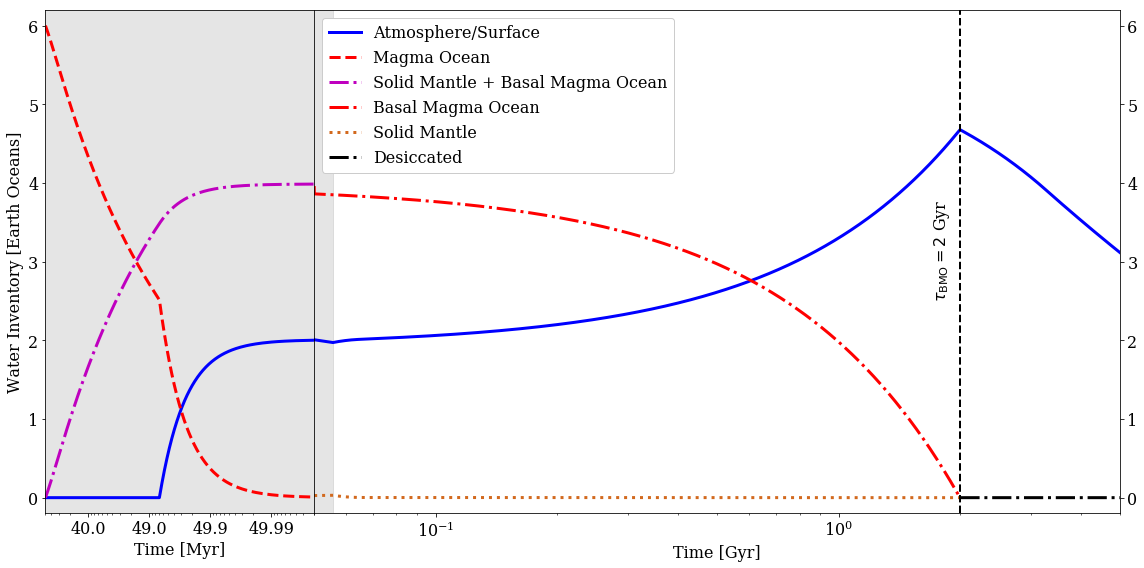

In [30]:
# Use a grey box to indicate the time when it is in a runaway greenhouse.

from matplotlib import gridspec
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(16,8))
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]

# First, find where runaway greenhouse ends, to be plotted as a vertical line.
# This corresponds to tau_RG >= tau_MO.
for idx in range(0, len(t_array)):
    
    if TOA_flux_array[idx]/4. < 282./(1.-alb):
        
        exit_time = t_array[idx]
        exit_idx = idx
        break

# This corresponds to tau_RG < tau_MO.
#for idx in range(0, len(t_MO_array)):
    
#    if TOA_flux_MO_array[idx]/4. < 282./(1.-alb):
        
#        exit_time = t_MO_array[idx]
#        exit_idx = idx
#        break
        
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

ax1 = plt.subplot(gs[0])
# Plot time data in reverse, then flip x-axis and change the axis labels.
plt.plot(t_MO_array[::-1]/year/1.0e6, M_atmo_array/1.4e21, linewidth=3, color='b', linestyle='-', label='Atmosphere')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_MO_array/1.4e21, linewidth=3, color='r', linestyle='--', label='Magma Ocean')
plt.plot(t_MO_array[::-1]/year/1.0e6, M_SM_array/1.4e21, linewidth=3, color='m', linestyle='-.', label='Solid Mantle + Basal Magma Ocean')
ax1.set_xscale('log')
# When tau_RG >= tau_MO:
plt.axvspan(t_MO_array[0], t_MO_array[-1], alpha=0.2, color='grey')
# When tau_RG < tau_MO:
#plt.axvspan(t_MO_array[exit_idx]/year/1.0e6, t_MO_array[-1]/year/1.0e6,  alpha=0.2, color='grey')
plt.ylim([-0.2, 6.2]) #nominal, 6 TO case
#plt.ylim([-0.2, 4.2])
plt.xlabel('Time [Myr]', fontsize=16)
plt.xlim([2e-3,tau_MO_file[tau_idx]])
plt.gca().invert_xaxis()
plt.gca().set_xticklabels(tau_MO_file[tau_idx]-plt.gca().get_xticks())
plt.ylabel('Water Inventory [Earth Oceans]', fontsize=16)

ax2 = plt.subplot(gs[1])
ax2.yaxis.tick_right()
## Re-colour/change linestyle if/when SURFACE becomes desiccated during cycling.
#des_surf_idx = np.where(W_s_array<1.29e16)[0][0]
#plt.semilogx(t_array[0:des_surf_idx-1]/year/1.0e9, W_s_array[0:des_surf_idx-1]/1.4e21, linewidth=3, color='b', linestyle='--', label='Atmosphere/Surface')
#plt.semilogx(t_array[des_surf_idx:]/year/1.0e9, W_s_array[des_surf_idx:]/1.4e21, linewidth=3, color='k', linestyle='-.') #, label='Desiccated')
## If surface doesn't become desiccated, just plot as-is.
plt.semilogx(t_array/year/1.0e9, W_s_array/1.4e21, linewidth=3, color='b', linestyle='-', label='Atmosphere/Surface')
plt.plot(10., 10., linewidth=3, color='r', linestyle='--', label='Magma Ocean')
plt.plot(10., 10., linewidth=3, color='m', linestyle='-.', label='Solid Mantle + Basal Magma Ocean')
plt.plot(10., 10., linewidth=3, color='r', linestyle='-.', label='Basal Magma Ocean')
## Re-colour/change linestyle if/when MANTLE becomes desiccated during cycling.
des_idx = np.where(W_m_array<1.29e16)[0][0]
plt.semilogx(t_array[0:des_idx-1]/year/1.0e9, W_m_array[0:des_idx-1]/1.4e21, linewidth=3, color='chocolate', linestyle=':', label='Solid Mantle')
plt.semilogx(t_array[des_idx:]/year/1.0e9, W_m_array[des_idx:]/1.4e21, linewidth=3, color='k', linestyle='-.', label='Desiccated')
## If mantle doesn't become desiccated, just plot as-is.
#plt.semilogx(t_array/year/1.0e9, W_m_array/1.4e21, linewidth=3, color='r', linestyle=':', label='Solid Mantle')
# Plot BMO inventory during cycling; don't plot if it is gone, after t=2 Gyr.
plt.semilogx(t_array[W_BMO_array>0.]/year/1.0e9, W_BMO_array[W_BMO_array>0.]/1.4e21, linewidth=3, color='r', linestyle='-.')#, label='Basal Magma Ocean')
# Vertical line indicating end of BMO injection
plt.axvline(2., color='k', linewidth=2, linestyle='--')
plt.text(1.85, 2.5, r'$\tau_{{\mathrm{{BMO}}}} = 2$ Gyr', color='k', rotation=90, rotation_mode='anchor', fontsize=16)
# Below line ONLY for when tau_RG > tau_MO; otherwise, no swath.
plt.axvspan(t_array[0]/year/1.0e9, t_array[exit_idx]/year/1.0e9, alpha=0.2, color='grey')
#plt.text(0.06, 3.5, 'end of RG', color='k', rotation=270, rotation_mode='anchor', fontsize=16)

#plt.axhline(y=1.29e16/1.4e21, color='k', linestyle=':',linewidth=3, label='Desiccation Limit')
plt.xlim([tau_MO_file[tau_idx]/1000., 5.0])
plt.ylim([-0.2, 6.2]) #nominal, 6 TO case
#plt.ylim([-0.2, 4.2])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.legend(loc='upper left', fontsize=16, framealpha=1)

plt.tight_layout()
fig.subplots_adjust(wspace=0)
#plt.savefig('Temporal_BasalMO_MO_Cycling_Loss_M5_6TO_MidHZ_50Myr.pdf', bbox_inches='tight')
#plt.savefig('Temporal_BasalMO_MO_Cycling_Loss_M5_4TO_MaxGH_100Myr.pdf', bbox_inches='tight')

# Plot changes in TOA flux/T_surf, and F_XUV/escape rates during cycling period as a function of time.

In [31]:
# Calculate F_XUV, to be plotted in the following panel.
F_XUV_array = np.zeros(len(t_array))

for idx in range(0,len(F_XUV_array)):
    
    F_XUV_array[idx] = F_XUV(t_array[idx], M, a_orb, params1, params2, params3)
    
# Saturation timescale, to be plotted as vertical line
t_sat = 1.0e9*year

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


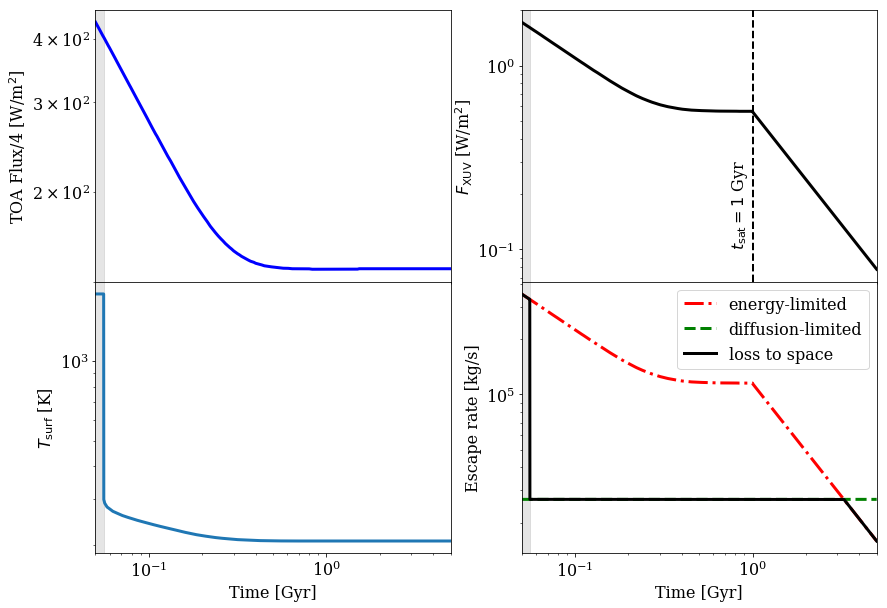

In [32]:
# Plot TOA flux over time, and a horizontal line with Goldblatt/Watson limit of 300 W/m^2.
# First, find where runaway greenhouse ends, to be plotted as a vertical line.
for idx in range(0, len(t_array)):
    
    if TOA_flux_array[idx]/4. < 282./(1.-alb):
        
        exit_time = t_array[idx]
        exit_idx = idx
        break

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(14,10))
plt.tight_layout()
ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(2, 2, 1)
plt.loglog(t_array/year/1.0e9, TOA_flux_array/4, linewidth=3, color='b') #divide by 4 for sphere
#plt.axhline(282./(1.-alb), color='k', linestyle='--', label='Simpson-Nakajima limit')
#plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
#plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([tau_MO/1.0e9, 5.0])
plt.ylabel(r'TOA Flux/4 [W/m$^2$]', fontsize=16)
#plt.legend(fontsize=16, loc='center right')
plt.axvspan(t_array[0]/year/1.0e9, t_array[exit_idx]/year/1.0e9, alpha=0.2, color='grey')

ax2 = plt.subplot(2, 2, 2)
plt.loglog(t_array/year/1.0e9, F_XUV_array, linewidth=3, color='k')
plt.axvline(t_sat/year/1.0e9, linestyle='--', linewidth=2, color='k')
plt.text(0.9, 0.1, r'$t_{{\mathrm{{sat}}}} = 1$ Gyr', color='k', rotation=90, rotation_mode='anchor', fontsize=16)
plt.xlim([tau_MO/1.0e9, 5.0])
plt.ylabel(r'$F_{{\mathrm{{XUV}}}}$ [W/m$^2$]', fontsize=16, labelpad=2.0)
plt.axvspan(t_array[0]/year/1.0e9, t_array[exit_idx]/year/1.0e9, alpha=0.2, color='grey')

ax3 = plt.subplot(2, 2, 3)
plt.loglog(t_array/year/1.0e9, T_surf_array, linewidth=3)
#plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
#plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([tau_MO/1.0e9, 5.0])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'$T_{{\mathrm{{surf}}}}$ [K]', fontsize=16)
#print('Minimum surface temperature = ', np.min(T_surf_array), 'K')
plt.axvspan(t_array[0]/year/1.0e9, t_array[exit_idx]/year/1.0e9, alpha=0.2, color='grey')

ax4 = plt.subplot(2, 2, 4)
plt.loglog(t_array/year/1.0e9, EL_array, linewidth=3, color='r', linestyle='-.', label='energy-limited')
plt.loglog(t_array/year/1.0e9, DL_array, linewidth=3, color='g', linestyle='--', label='diffusion-limited')
#plt.axvline(exit_time/year/1.0e9, color='k', linestyle='-.')
#Plot in bold the actual loss prescription being followed, based on TOA flux runaway greenhouse limit.
plt.loglog(t_array/year/1.0e9, loss_array, linewidth=3, color='k', label='loss to space')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.xlim([tau_MO/1.0e9, 5.0])
plt.ylabel('Escape rate [kg/s]', fontsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.axvspan(t_array[0]/year/1.0e9, t_array[exit_idx]/year/1.0e9, alpha=0.2, color='grey')

#plt.savefig('PostMO_TOAFlux_LossRates_6TO_MidHZ_50Myr_loglog.pdf', bbox_inches='tight')

# Writing to & reading from file without save text.

In [33]:
## Package needed for f.write
#import os.path

## Save path
#save_path = '/Users/admin/Desktop/Code_for_Others/Ben_MO_Cycling_Loss/'

## Save file
#save_file = 'MOresults.txt'

## Filename joins path and file for writing
#filename = os.path.join(save_path, save_file)

## Open file with writing permission
#f = open(filename, 'w')

## Write data for a given index/timestep in loop; tab delineator \t separates data, \n is new line
#f.write(str(variable1[index]) + '\t' + str(variable2[index]) + '\n')

## Close file at end of loop.
#f.close()

######################
## To read in, load file.
#result = np.loadtxt(filename)

## Read in saved data from loaded file; result[:,0] = [all rows, column 0]
#saved_data1[index1,index2,:] = result[:,0]
#saved_data2[index1,index2,:] = result[:,1]
#...